# Libraries import

In [4]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
from concurrent.futures import ThreadPoolExecutor
import requests
import random
import unicodedata

# Topics parsing

In [6]:
url = 'https://citaty.info/topic'
page = urlopen(url)
html = page.read().decode('utf-8')
soup = BeautifulSoup(html, 'html.parser')
quotes_topic_category_links = []
for element in soup.find_all('div', class_ = 'term-name'):
    link = element.find('a').get('href')
    quotes_topic_category_links.append(link)

print(f'Amount of quotes topics: {len(quotes_topic_category_links)}')

Amount of quotes topics: 100


# Quotes parsing

In [7]:
user_agents = [
    'Mozilla/5.0 (Linux; Android 12; V2110 Build/SP1A.210812.003) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/116.0.0.0 Mobile Safari/537.36 GNews Android/2022150848',
    'Mozilla/5.0 (Linux; Android 11; Mi 9T Pro Build/RKQ1.200826.002; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/116.0.0.0 Mobile Safari/537.36 Instagram 299.0.0.34.111 Android (30/11; 440dpi; 1080x2210; Xiaomi; Mi 9T Pro; raphael; qcom; it_IT; 512770468)',
    'Mozilla/5.0 (Linux; Android 12; CPH2009 Build/RKQ1.211103.002) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/116.0.0.0 Mobile Safari/537.36 GNews Android/2022150848',
    'Mozilla/5.0 (Linux; Android 12; moto g32 Build/S2SNS32.34-72-31-1; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/116.0.0.0 Mobile Safari/537.36',
    'Mozilla/5.0 (Linux; Android 9; SM-J415FN Build/PPR1.180610.011) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/116.0.0.0 Mobile Safari/537.36 GNews Android/2022150848',
    'Mozilla/5.0 (Linux; arm_64; Android 8.0.0; SM-A720F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 YaBrowser/23.7.5.95.00 SA/3 Mobile Safari/537.36',
    'Mozilla/5.0 (Linux; arm_64; Android 11; SM-N985F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115}.0.5825.155 Mobile Safari/537.36',
    'Mozilla/5.0 (Linux; arm_64; Android 8.1.0; BV9500Pro) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 YaBrowser/23.5.3.75.00 SA/3 Mobile Safari/537.36',
    'Mozilla/5.0 (Linux; arm_64; Android 11; SM-A525F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.5825.33 Mobile Safari/537.36',
    'Mozilla/5.0 (Linux; arm_64; Android 11; Redmi 5 Plus) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.5730.173 Mobile Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.106 Safari/537.36'
]

def get_user_agent(user_agents):
    return user_agents[random.randint(0, len(user_agents) - 1)]

def make_request(url, retry = 5, verbose = False):
    headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'user-agent': get_user_agent(user_agents)
    }
    try:
        response = requests.get(url = url, headers = headers)
        if verbose:
            print(f'[Response] from {url} - {response.status_code}')
    except Exception as ex:
        time.sleep(3)
        if retry:
            print(f'[Retry] #{retry}: {url}')
            return make_request(url, retry = (retry - 1))
        else:
            raise
    else:
        return response
    
def process_text(input_text):
    text = unicodedata.normalize('NFKD', input_text)
    text = text.replace('\n', ' ')
    return text

In [8]:
class Quote:
    def __init__(self, quote_text, source):
        self.quote_text = quote_text
        self.source = source

def get_quotes_from_topic(quotes_topic_category_link):
    parsed_quotes = []
    pages = 50
    for page in range(0, pages):
        link = f'{quotes_topic_category_link}?page={page}'
        try:
            response = make_request(link)
            soup = BeautifulSoup(response.text, 'html.parser')
            nodes = soup.find_all('div', class_ = 'node__content')
            for node in nodes:
                quote_text = process_text(node.find('p').text)
                source_div = node.find('div', class_ = 'field-type-taxonomy-term-reference')
                source_a = source_div.find('a')
                source = process_text(source_a.text if source_a != None else '---')
                parsed_quotes.append(Quote(quote_text = quote_text, source = source))
        except Exception as ex:
            print(f'[Error] occured when parsing link {link} - {ex}')
            continue
    print(f'[Done]: {quotes_topic_category_link}')
    return parsed_quotes

In [12]:
with ThreadPoolExecutor() as executor:
    results = executor.map(get_quotes_from_topic, quotes_topic_category_links)
    
all_quotes = []
for result in results:
    all_quotes.extend(result)
    
print(f'Amount of parsed quotes: {len(all_quotes)}')

[Error] occured when parsing link https://citaty.info/category/krasivye-citaty?page=12 - 'NoneType' object has no attribute 'text'
[Error] occured when parsing link https://citaty.info/topic/lyubov?page=35 - 'NoneType' object has no attribute 'text'
[Error] occured when parsing link https://citaty.info/topic/zhizn?page=32 - 'NoneType' object has no attribute 'find'
[Done]: https://citaty.info/category/krasivye-citaty
[Done]: https://citaty.info/category/motiviruyushie-citaty
[Done]: https://citaty.info/category/smeshnye-citaty
[Done]: https://citaty.info/category/sarkastichnye-citaty
[Done]: https://citaty.info/topic/zhenshiny
[Done]: https://citaty.info/category/grustnye-citaty
[Done]: https://citaty.info/topic/lyubov
[Done]: https://citaty.info/category/ironichnye-citaty
[Done]: https://citaty.info/topic/chelovek-lyudi
[Error] occured when parsing link https://citaty.info/topic/druzya-druzhba?page=2 - 'NoneType' object has no attribute 'text'
[Done]: https://citaty.info/category/zhiz

# Saving quotes to .csv file

In [14]:
df_all_quotes = pd.DataFrame([vars(quote) for quote in all_quotes])
df_quotes = df_all_quotes.drop_duplicates(ignore_index = True)
df_quotes.to_csv('quotes_citaty_info.csv', index = False)

print(f'Amount of duplicates: {len(df_all_quotes) - len(df_quotes)}')
print(f'Total quotes amount: {len(df_quotes)}')

Amount of duplicates: 16942
Total quotes amount: 66240


In [29]:
df_quotes

,quote_text,source
0,"Ничто так не выдает человека, как то, над чем ...",Иоганн Вольфганг фон Гёте
1,"Иногда момент, который ты так долго ждал, при...",Клиника (Scrubs)
2,Такой вот парадокс: мы совершаем подвиги для ...,Смешарики
3,"Проще расстаться с человеком, чем с иллюзиями ...",Марта Кетро
4,"Самое худшее, когда нужно ждать и не можешь ни...",Эрих Мария Ремарк
...,...,...
66235,"Нет, конечно же, не страсть. Нежность. А тебе...",Анна Михайловна Островская
66236,"Я знаю: пройден путь разлуки и ненастья, И то...",Владимир Набоков
66237,"Время года и время суток неважно, Разница в ро...",Анна Кудашева
66238,"Можно тебя на короткий вдох, выдох, мурашек б...",Джио Россо


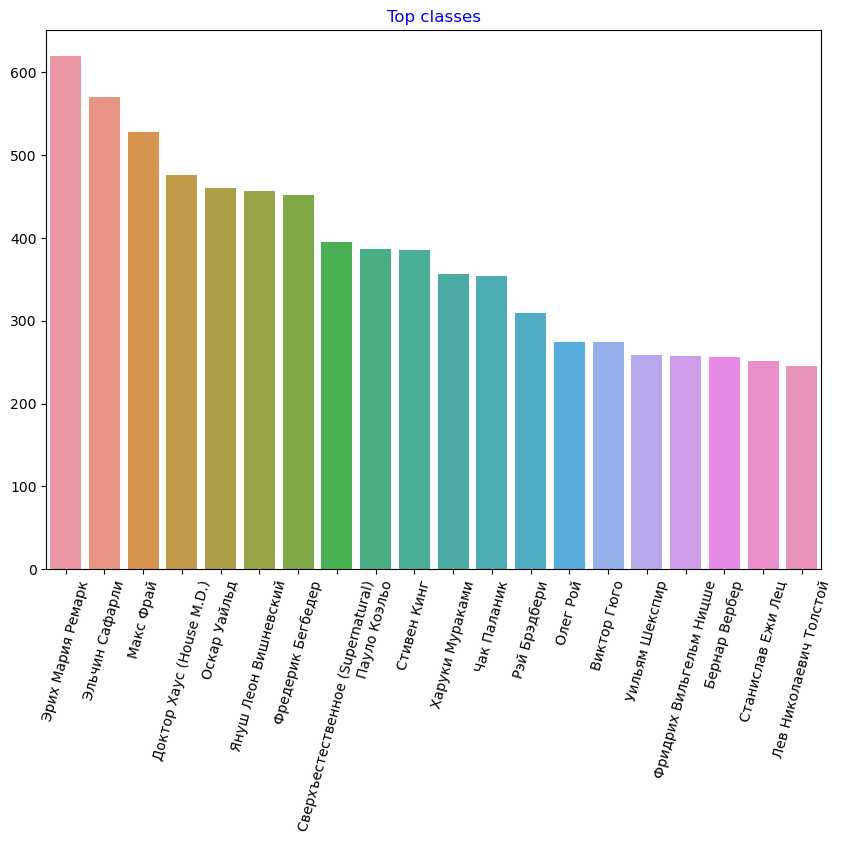

In [23]:
import matplotlib.pyplot as plt
import seaborn as sb

def show_top_classes(df, column, num_of_top_classes = None):
    top = df[column].value_counts()
    if num_of_top_classes != None:
        top = top[:num_of_top_classes]
    plt.figure(figsize = (10, 7))
    sb.barplot(x = top.index, y = top.values)
    plt.xticks(rotation = 75)
    plt.title('Top classes', color = 'blue')
    plt.show()
    
show_top_classes(df_quotes, 'source', 20)

# Adding quotes from the "Russian gang quotes" dataset

Dataset source: https://www.kaggle.com/datasets/egoluback/russian-gang-quotes/

In [24]:
df_gang_quotes_source = pd.read_csv('russian_gang_quotes.csv')
gang_quotes = []
for quote_text in df_gang_quotes_source['quote_text']:
    gang_quotes.append(Quote(quote_text = quote_text, source = 'Пацанские паблики'))
df_gang_quotes = pd.DataFrame([vars(quote) for quote in gang_quotes])
df_gang_quotes

,quote_text,source
0,"Пацан высказался, потом делом подтвердил слова...",Пацанские паблики
1,Цена пацана измеряется выполнением его обещаний.,Пацанские паблики
2,"Я не матерюсь, а лишь употребляю ненормативную...",Пацанские паблики
3,Самое позорное для пацана - поливать грязью ту...,Пацанские паблики
4,"Шесть лет не пил, не курил, по бабам не шлялся...",Пацанские паблики
...,...,...
841,"Если друзья мои станут врагами, и в суете прод...",Пацанские паблики
842,"Никогда не говори людям о своих бедах, большин...",Пацанские паблики
843,Все хорошо. Земля вертится. Друзья звонят. И е...,Пацанские паблики
844,"Когда идёшь на уступки ради человека, который ...",Пацанские паблики


In [28]:
df_final = pd.concat([df_quotes, df_gang_quotes])
df_final

,quote_text,source
0,"Ничто так не выдает человека, как то, над чем ...",Иоганн Вольфганг фон Гёте
1,"Иногда момент, который ты так долго ждал, при...",Клиника (Scrubs)
2,Такой вот парадокс: мы совершаем подвиги для ...,Смешарики
3,"Проще расстаться с человеком, чем с иллюзиями ...",Марта Кетро
4,"Самое худшее, когда нужно ждать и не можешь ни...",Эрих Мария Ремарк
...,...,...
841,"Если друзья мои станут врагами, и в суете прод...",Пацанские паблики
842,"Никогда не говори людям о своих бедах, большин...",Пацанские паблики
843,Все хорошо. Земля вертится. Друзья звонят. И е...,Пацанские паблики
844,"Когда идёшь на уступки ради человека, который ...",Пацанские паблики


In [36]:
# Shuffling the dataset
df_final = df_final.sample(frac = 1)
df_final = df_final.reset_index().drop(columns = ['index'])
df_final

,quote_text,source
0,"— Достаточно, — резко оборвала его Рейна. — А...",Рик Риордан
1,Россия стоит между Азией и Европой. Мы вам с...,Владимир Вольфович Жириновский
2,"Мы убьем его добротой, но только вместо добро...",Южный парк (South Park)
3,"Дамы, не худейте. Оно вам надо? Уж лучше к ст...",Фаина Раневская
4,Недоверие к друзьям — вершина бесчестья.,Джоан Роулинг
...,...,...
67081,Правдивый человек в конце концов приходит к п...,Фридрих Вильгельм Ницше
67082,Почему Булгаков написал в «Мастере и Маргарите...,Александра Маринина
67083,"Будучи трупом, я получил алиби и свободу дейс...",Фанфик по комиксу Тёмный дворецкий (Kuroshi...
67084,"Не знаю, знаешь ли ты или нет, но я чокнутая н...",Секс по дружбе (Friends with Benefits)


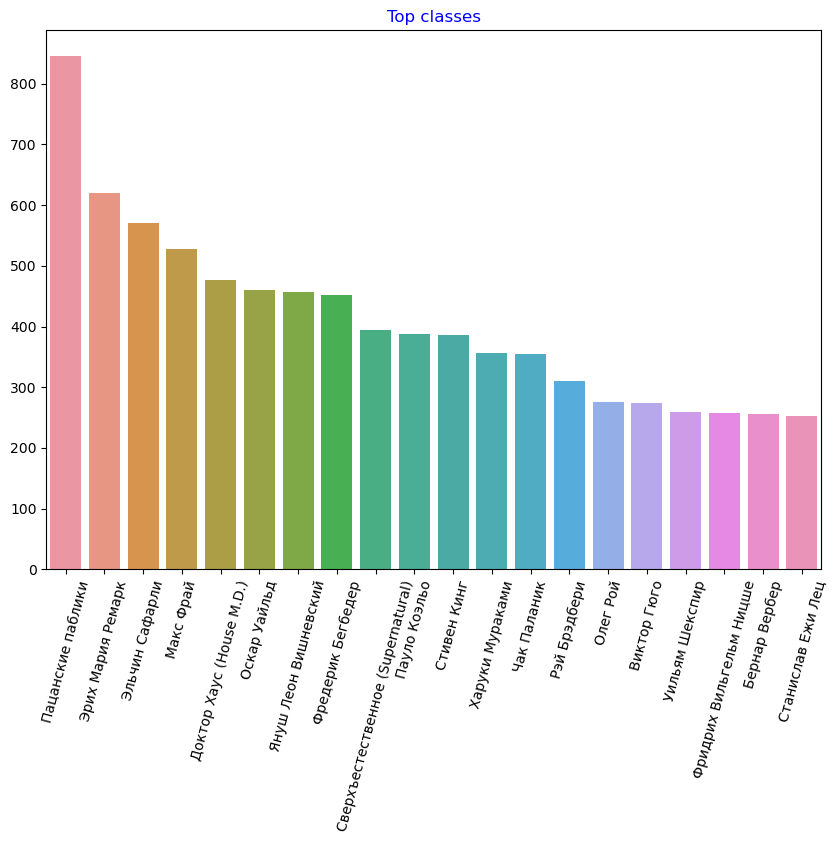

In [37]:
show_top_classes(df_final, 'source', 20)

In [38]:
df_final.to_csv('quotes_final.csv', index = False)

# Reading quotes from the resulting .csv file

In [39]:
quotes_df = pd.read_csv('quotes_final.csv')
quotes_df

,quote_text,source
0,"— Достаточно, — резко оборвала его Рейна. — А...",Рик Риордан
1,Россия стоит между Азией и Европой. Мы вам с...,Владимир Вольфович Жириновский
2,"Мы убьем его добротой, но только вместо добро...",Южный парк (South Park)
3,"Дамы, не худейте. Оно вам надо? Уж лучше к ст...",Фаина Раневская
4,Недоверие к друзьям — вершина бесчестья.,Джоан Роулинг
...,...,...
67081,Правдивый человек в конце концов приходит к п...,Фридрих Вильгельм Ницше
67082,Почему Булгаков написал в «Мастере и Маргарите...,Александра Маринина
67083,"Будучи трупом, я получил алиби и свободу дейс...",Фанфик по комиксу Тёмный дворецкий (Kuroshi...
67084,"Не знаю, знаешь ли ты или нет, но я чокнутая н...",Секс по дружбе (Friends with Benefits)


# Putting quotes in the .txt file

In [40]:
with open('quotes.txt', 'w', encoding = 'utf-8') as f:
    for quote in quotes_df['quote_text']:
        f.write(f'{quote}\n')